# Expensiveness classification (binary classification)

The problem scope defines a product as expensive if the product price is above the percentile 85. We predict 1 (True) if product is expensive, 0 (False) if not.

$Price_p > Percentile[85]$

Naturally, this creates an imbalanced issue on the dataset, since

In [5]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import joblib

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, RocCurveDisplay
import json

import os
from skopt import BayesSearchCV
from skopt.space import Real

from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT *
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               LIMIT 10000
               """
data = pd.read_sql(sql_query, engine)
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id
0,4034097578,532,Naf Naf,2024-02-21,L / 40 / 12,9.0,1,39,2024-01-28,15,15,1,1.45,Nîmes,Francia,Azul,Muito bom,Veste écossaise naf naf étiquette composition ...,None,19196409
1,4031750967,193,Camaïeu,2024-02-21,L / 40 / 12,26.0,0,2,2024-01-28,5,5,1,0.95,Nîmes,Francia,Azul claro,Muito bom,Tee-shirt manches 3/4\nPas de défauts\nDans ...,None,19196409
2,4029787964,1685,NUK,2024-02-21,,None,0,3,2024-01-27,3,3,1,0.85,Nîmes,Francia,None,Muito bom,Stérilisateur vapeur biberon micro onde \n\nPa...,None,19196409
3,4027379386,2949,Tamaris,2024-02-21,37,7.0,3,24,2024-01-27,30,30,1,2.20,Nîmes,Francia,Vermelho,Muito bom,"nu-pieds portés une fois, en excellent état...",None,19196409
4,4103816120,1090,Shein,2024-02-21,S / 36 / 8,1.0,0,4,2024-02-15,20,20,2,1.70,Saint-Josse-Ten-Noode,Belgique,Preto,Novo sem etiquetas,En bon état,None,82410091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3910701942,185,,2024-02-21,M / 38 / 10,1.0,0,4,2023-12-27,10,10,1,1.20,Latina,Italia,Preto,Muito bom,Taglia M ma calzano piccoli,None,54230957
9996,3910696707,1090,Dixie,2024-02-21,M / 38 / 10,1.0,11,144,2023-12-27,19,19,3,1.65,Latina,Italia,Preto,Muito bom,Ottime condizioni,None,54230957
9997,3910693187,1071,Vicolo,2024-02-21,S / 36 / 8,7.0,12,161,2023-12-27,10,10,1,1.20,Latina,Italia,Vermelho,Muito bom,Ottime condizioni,None,54230957
9998,3910689721,185,Rinascimento,2024-02-21,L / 40 / 12,1.0,4,25,2023-12-27,12,12,1,1.30,Latina,Italia,Preto,Muito bom,Rinascimento,None,54230957


In [6]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(data["price_numeric"].values.reshape(-1, 1))
y_pred_train = clf.predict(data["price_numeric"].values.reshape(-1, 1))
data["svm"] = y_pred_train
data = data[data["svm"] == 1]
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id,svm
0,4034097578,532,Naf Naf,2024-02-21,L / 40 / 12,9.0,1,39,2024-01-28,15,15,1,1.45,Nîmes,Francia,Azul,Muito bom,Veste écossaise naf naf étiquette composition ...,None,19196409,1
1,4031750967,193,Camaïeu,2024-02-21,L / 40 / 12,26.0,0,2,2024-01-28,5,5,1,0.95,Nîmes,Francia,Azul claro,Muito bom,Tee-shirt manches 3/4\nPas de défauts\nDans ...,None,19196409,1
2,4029787964,1685,NUK,2024-02-21,,None,0,3,2024-01-27,3,3,1,0.85,Nîmes,Francia,None,Muito bom,Stérilisateur vapeur biberon micro onde \n\nPa...,None,19196409,1
3,4027379386,2949,Tamaris,2024-02-21,37,7.0,3,24,2024-01-27,30,30,1,2.20,Nîmes,Francia,Vermelho,Muito bom,"nu-pieds portés une fois, en excellent état...",None,19196409,1
5,4094551143,1132,New Yorker,2024-02-21,S / 36 / 8,2.0,0,4,2024-02-12,4,4,1,0.90,Saint-Josse-Ten-Noode,Belgique,Castanho,Novo sem etiquetas,En bon état,None,82410091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,3910733339,1065,Fornarina,2024-02-21,M / 38 / 10,15.0,0,1,2023-12-27,10,10,1,1.20,Latina,Italia,Multi,Muito bom,Ottime condizioni,None,54230957,1
9995,3910701942,185,,2024-02-21,M / 38 / 10,1.0,0,4,2023-12-27,10,10,1,1.20,Latina,Italia,Preto,Muito bom,Taglia M ma calzano piccoli,None,54230957,1
9997,3910693187,1071,Vicolo,2024-02-21,S / 36 / 8,7.0,12,161,2023-12-27,10,10,1,1.20,Latina,Italia,Vermelho,Muito bom,Ottime condizioni,None,54230957,1
9998,3910689721,185,Rinascimento,2024-02-21,L / 40 / 12,1.0,4,25,2023-12-27,12,12,1,1.30,Latina,Italia,Preto,Muito bom,Rinascimento,None,54230957,1


In [7]:
#data = data[data["catalog_id"] == 221]
# detected outliers
# pick outliers
# for each catalog_id
# percentile tag outliers (0 if below Q3, 1 if above) (has to be binary)
# this is an instance of an imbalance dataset
data["target"] = data["price_numeric"].apply(lambda x: 1 if x > data["price_numeric"].quantile(0.85) else 0)
# build a classification algorithm to predict it

# data balancing
def stratified_sampling(group):
    return group.sample(min(len(group), target_sample_size), replace=False)

# Calculate the target sample size (assuming equal sizes for both classes)
target_sample_size = data['target'].value_counts().min()

# Apply the stratified sampling using groupby and apply
data = data.groupby('target', group_keys=False).apply(stratified_sampling)


# data transformation prior to training
ordinal_encoder = OrdinalEncoder(categories=[["Satisfatório", "Bom", "Muito bom", "Novo sem etiquetas", "Novo com etiquetas"]])
status = pd.DataFrame(ordinal_encoder
                        .fit_transform(data[['status']])
                        ).add_prefix("status_")
                        
status_decoded = ordinal_encoder.get_feature_names_out(input_features= ["status"])

catalog_onehot_encoder = OneHotEncoder(sparse_output=False)
catalog_id = pd.DataFrame(catalog_onehot_encoder
                            .fit_transform(data[['catalog_id']])
                            ).add_prefix("catalog_id_")

#print(pd.DataFrame(size_onehot_encoder.inverse_transform(size_title), columns=['Category']))
catalog_id_decoded = catalog_onehot_encoder.get_feature_names_out(input_features= ["catalog_id"])

size_onehot_encoder = OneHotEncoder(sparse_output=False)
size_title = pd.DataFrame(size_onehot_encoder
                            .fit_transform(data[['size_title']])
                            ).add_prefix("size_title_")

#print(pd.DataFrame(size_onehot_encoder.inverse_transform(size_title), columns=['Category']))
size_decoded = size_onehot_encoder.get_feature_names_out(input_features= ["size_title"])

brand_onehot_encoder = OneHotEncoder(sparse_output=False)
brand_title = pd.DataFrame(brand_onehot_encoder
                            .fit_transform(data[['brand_title']])
                            ).add_prefix("brand_title_")

brand_decoded = brand_onehot_encoder.get_feature_names_out(input_features= ["brand_title"])

#print(pd.DataFrame(brand_onehot_encoder.inverse_transform(brand_title), columns=['Category']))

labels = pd.concat([size_title, status, brand_title, catalog_id], axis=1, ignore_index=False) #.fillna(0)
cols = size_decoded.tolist() + status_decoded.tolist() + brand_decoded.tolist()

model_params = pd.DataFrame([labels.columns, cols]).T
model_params.columns = ["Labels", "Decoded"]
#model_params.to_csv("model_development/model_artifacts/params.csv")
model_params

C:\Users\Miguel\AppData\Local\Temp\ipykernel_13708\1697687993.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"] = data["price_numeric"].apply(lambda x: 1 if x > data["price_numeric"].quantile(0.85) else 0)


,Labels,Decoded
0,size_title_0,size_title_
1,size_title_1,"size_title_1-2 anos, 49 cm"
2,size_title_2,size_title_1-3 meses / 56 cm
3,size_title_3,size_title_10 anos / 140 cm
4,size_title_4,size_title_100 cm
...,...,...
1344,catalog_id_452,None
1345,catalog_id_453,None
1346,catalog_id_454,None
1347,catalog_id_455,None


In [8]:
X_train, X_test, y_train, y_test = train_test_split(labels, data["target"], random_state=42)

# complexity nf(n)**n_features
lr = LogisticRegression(max_iter=1000, 
                        solver = 'saga')

# parameter space
parameters = {'C': Real(1e-1, 1e+1, 
                        prior='log-uniform')}

# Specify scoring metrics
# main scoring param has to be defined as "score" since scikit is fetching "mean_test_score"
scoring = {
        "score" : "roc_auc",
        "specificity": make_scorer(specificity_score, 
                                   average="weighted"),
        "recall" : "recall",
        "accuracy" : "accuracy",
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_lr = BayesSearchCV(lr, 
                      parameters, 
                      cv=10, 
                      scoring=scoring, 
                      refit="score", 
                      random_state=42, 
                      n_iter=10, 
                      return_train_score=True)

# We need to fit the BayesSearchCV object to the train data in order to make predictions with the best model later
gs_lr.fit(X_train, y_train)

# Run nested cross-validation over 10 folds
lr_scores = cross_validate(gs_lr, X_test, y_test, cv=10, n_jobs= 1, verbose=1,
                        return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
lr_preds = cross_val_predict(lr, X_test, y_test, cv=10, n_jobs=-1)

In [9]:
import numpy as np 
import matplotlib.pyplot as plt

for score in lr_scores:
        print(f"{score:<17}: {np.mean(lr_scores[score]):.2f}")

best_lr_model = gs_lr.best_estimator_
print(best_lr_model)
print(len(best_lr_model.coef_[0]))
print(len(cols))

fit_time         : 54.85
score_time       : 0.02
test_score       : 0.81
train_score      : 1.00
test_specificity : 0.73
train_specificity: 0.98
test_recall      : 0.72
train_recall     : 0.98
test_accuracy    : 0.73
train_accuracy   : 0.98
LogisticRegression(C=2.9380287142759305, max_iter=1000, solver='saga')
1349
892


LogisticRegression(C=1.2172976749510152, max_iter=1000, solver='saga')

               precision    recall  f1-score   support

Not expensive       0.73      0.75      0.74       238
    Expensive       0.74      0.71      0.72       233

     accuracy                           0.73       471
    macro avg       0.73      0.73      0.73       471
 weighted avg       0.73      0.73      0.73       471



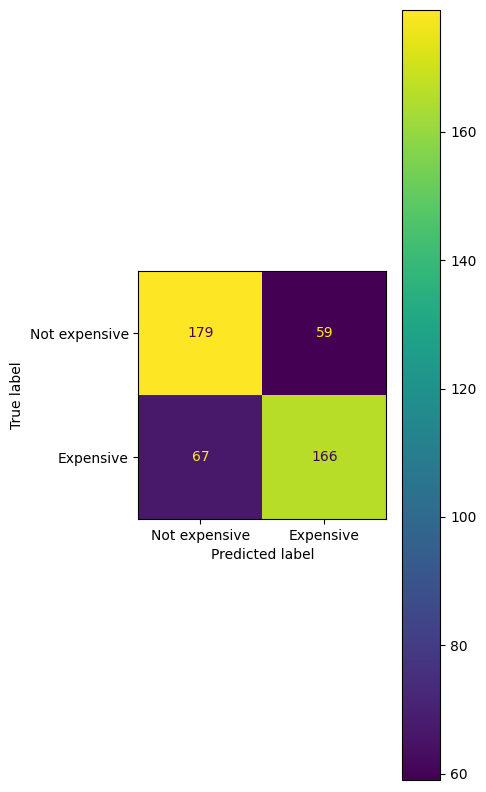

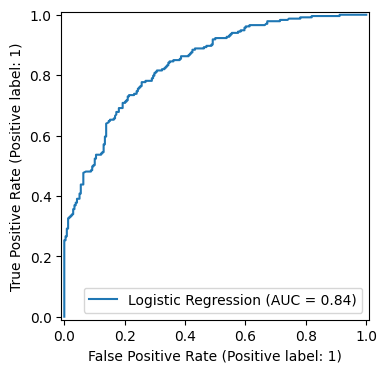

In [10]:
f, axs = plt.subplots(1, 1, figsize=(4, 10))
disp = ConfusionMatrixDisplay.from_predictions(y_test, lr_preds,
                                        display_labels=['Not expensive', 'Expensive'],
                                        normalize=None,
                                        ax=axs)

print(classification_report(y_test, lr_preds, target_names=['Not expensive', 'Expensive']))

f, axs = plt.subplots(1, 1, figsize=(5, 4))
roc = RocCurveDisplay.from_estimator(gs_lr.best_estimator_, X_test, y_test, 
                               name="Logistic Regression",
                               ax=axs)

.values =
array([[ 0.02938287,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02938287,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18049479,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02938287,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02938287,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02938287,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([-0.11338686, -0.11338686, -0.11338686, -0.11338686, -0.11338686,
       -0.11338686, -0.11338686, -0.11338686, -0.11338686, -0.11338686,
       -0.11338686, -0.11338686, -0.11338686, -0.11338686, -0.11338686,
       -0.11338686, -0.11338686, -0.11338686, -0.11338686, -0.11338686,
       -0.11338686, -0.11338686, -0.11338686, -0.11338686, -0.11338686,
 

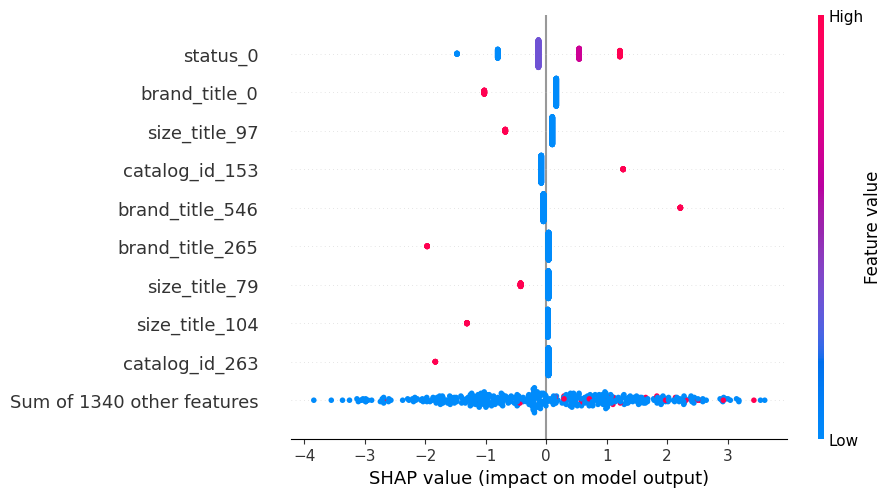

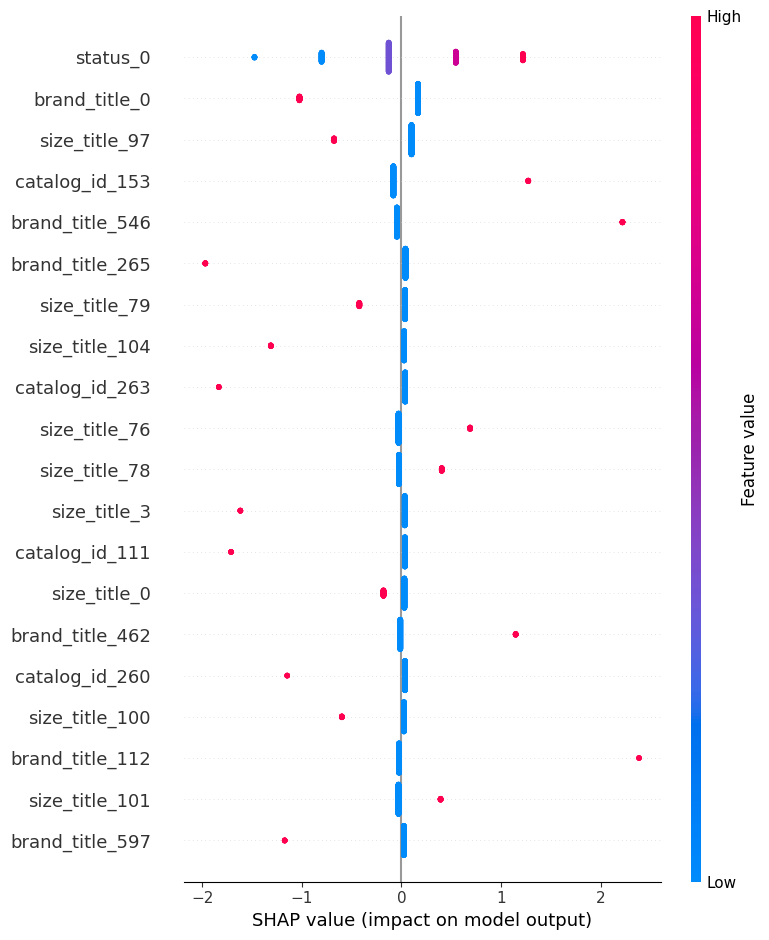

In [11]:
#coefficients_df = pd.DataFrame({'Feature': cols, 'Coefficient': best_lr_model.coef_[0]})
#coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False).head(10)
#print(coefficients_df)
"""
joblib.dump(best_lr_model, 
            'model_development/model_artifacts/logisticregression.pkl')

f, axs = plt.subplots(1, 1, figsize=(4, 10))
disp = ConfusionMatrixDisplay.from_predictions(y_test, lr_preds,
                                        display_labels=['Not expensive', 'Expensive'],
                                        normalize=None,
                                        ax=axs)

print(classification_report(y_test, lr_preds, target_names=['Not expensive', 'Expensive']))

f, axs = plt.subplots(1, 1, figsize=(5, 4))
roc = RocCurveDisplay.from_estimator(gs_lr.best_estimator_, X_test, y_test, 
                               name="Logistic Regression",
                               ax=axs)

"""

import shap

explainer = shap.Explainer(best_lr_model, 
                                 X_train, 
                                 feature_names=cols)

shap_values = explainer(X_test)
print(shap_values)

shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, 
                  X_test)
plt.show()